<a href="https://colab.research.google.com/github/omorros/SnapShelf-Notebooks/blob/main/03_efficientnet_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ================================================================
# SNAPSHELF - EFFICIENTNET TRANSFER LEARNING
# ================================================================
# Project:      SnapShelf - Smart Food Inventory Management
# Module:       MOD002691 - Final Project (BSc Software Engineering)
# Institution:  Anglia Ruskin University, Cambridge
# Author:       Oriol Morros Vilaseca (SID: 2270056)
# Supervisor:   Mr Vitaliy Milke
# Date:         January 2026
# ================================================================
#
# PURPOSE:
# This notebook trains an EfficientNetB0 model using transfer learning
# for food image classification. The base model is pre-trained on
# ImageNet and fine-tuned on the SnapShelf dataset.
#
# This is Model 2 of 3 in the comparison study:
#   1. Custom CNN (trained from scratch)
#   2. EfficientNetB0 (this notebook)
#   3. ResNet-50 (transfer learning)
#
# RESEARCH QUESTION:
# How do different image classification approaches compare in
# accuracy, inference time, and computational efficiency for
# household food item recognition?
#
# INPUT:
#   - snapshelf_dataset_14classes_70-15-15.zip (from Notebook 01)
#
# OUTPUT:
#   - Trained model: snapshelf_efficientnet.keras
#   - Training history and metrics
#   - Evaluation results on test set
#
# ================================================================

import sys
import platform
from datetime import datetime

print("=" * 65)
print("SNAPSHELF AI - EFFICIENTNET TRANSFER LEARNING")
print("=" * 65)
print(f"Execution Date:  {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Python Version:  {sys.version.split()[0]}")
print(f"Platform:        {platform.platform()}")
print("=" * 65)

SNAPSHELF AI - EFFICIENTNET TRANSFER LEARNING
Execution Date:  2026-01-03 21:20:59
Python Version:  3.12.12
Platform:        Linux-6.6.105+-x86_64-with-glibc2.35


In [2]:
# ================================================================
# CELL 2: IMPORT LIBRARIES & CHECK GPU
# ================================================================
# TensorFlow/Keras for model building and training.
# EfficientNetB0 is imported from keras.applications.
# ================================================================

import os
import zipfile
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# -----------------------------
# CHECK GPU AVAILABILITY
# -----------------------------
print("=" * 65)
print("ENVIRONMENT CHECK")
print("=" * 65)

print(f"\nTensorFlow Version: {tf.__version__}")

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU Available:      Yes")
    print(f"GPU Device:         {gpus[0].name}")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print(f"GPU Available:      No (training will be slow)")

print(f"Random Seed:        {SEED}")
print(f"\nLibraries imported successfully.")

ENVIRONMENT CHECK

TensorFlow Version: 2.19.0
GPU Available:      Yes
GPU Device:         /physical_device:GPU:0
Random Seed:        42

Libraries imported successfully.


In [3]:
# ================================================================
# CELL 3: MOUNT GOOGLE DRIVE & LOAD DATASET
# ================================================================
# Loads the prepared dataset from Notebook 01.
# Extracts to local storage for faster training.
# ================================================================

from google.colab import drive

# Mount Google Drive
if not os.path.exists('/content/drive/MyDrive'):
    drive.mount('/content/drive')

# -----------------------------
# CONFIGURATION
# -----------------------------
DATASET_ZIP = "/content/drive/MyDrive/snapshelf_datasets/snapshelf_dataset_14classes_70-15-15.zip"
LOCAL_DATASET = "/content/snapshelf_dataset"

print("=" * 65)
print("LOADING DATASET")
print("=" * 65)

# Verify zip file exists
if not os.path.exists(DATASET_ZIP):
    raise FileNotFoundError(f"Dataset not found: {DATASET_ZIP}")

zip_size_mb = os.path.getsize(DATASET_ZIP) / (1024 * 1024)
print(f"\nDataset archive: {DATASET_ZIP}")
print(f"Archive size:    {zip_size_mb:.1f} MB")

# -----------------------------
# EXTRACT DATASET
# -----------------------------
print(f"\nExtracting to: {LOCAL_DATASET}")

# Clean extraction directory
if os.path.exists(LOCAL_DATASET):
    shutil.rmtree(LOCAL_DATASET)

# Extract
with zipfile.ZipFile(DATASET_ZIP, 'r') as zip_ref:
    zip_ref.extractall(LOCAL_DATASET)

print("Extraction complete.")

# -----------------------------
# VERIFY STRUCTURE
# -----------------------------
TRAIN_DIR = f"{LOCAL_DATASET}/train"
VAL_DIR = f"{LOCAL_DATASET}/val"
TEST_DIR = f"{LOCAL_DATASET}/test"

print(f"\nDataset structure:")
for split_name, split_dir in [("Train", TRAIN_DIR), ("Val", VAL_DIR), ("Test", TEST_DIR)]:
    if os.path.exists(split_dir):
        n_classes = len(os.listdir(split_dir))
        n_images = sum(len(files) for _, _, files in os.walk(split_dir))
        print(f"  {split_name + ':':<8} {n_classes} classes, {n_images:,} images")
    else:
        print(f"  {split_name}: NOT FOUND")

# Get class names
CLASS_NAMES = sorted(os.listdir(TRAIN_DIR))
NUM_CLASSES = len(CLASS_NAMES)

print(f"\nClasses ({NUM_CLASSES}): {', '.join(CLASS_NAMES)}")

Mounted at /content/drive
LOADING DATASET

Dataset archive: /content/drive/MyDrive/snapshelf_datasets/snapshelf_dataset_14classes_70-15-15.zip
Archive size:    2445.3 MB

Extracting to: /content/snapshelf_dataset
Extraction complete.

Dataset structure:
  Train:   14 classes, 117,151 images
  Val:     14 classes, 25,099 images
  Test:    14 classes, 25,116 images

Classes (14): apple, banana, bell_pepper_green, bell_pepper_red, carrot, cucumber, grape, lemon, onion, orange, peach, potato, strawberry, tomato


In [4]:
# ================================================================
# CELL 4: CONFIGURE DATA GENERATORS
# ================================================================
# EfficientNet requires 224x224 input images.
# Uses EfficientNet's built-in preprocessing function.
# ================================================================

# -----------------------------
# HYPERPARAMETERS
# -----------------------------
IMG_SIZE = (224, 224)  # EfficientNetB0 standard input size
BATCH_SIZE = 32
COLOR_MODE = 'rgb'

print("=" * 65)
print("DATA GENERATOR CONFIGURATION")
print("=" * 65)

print(f"\nImage size:    {IMG_SIZE[0]}x{IMG_SIZE[1]} pixels (EfficientNet standard)")
print(f"Batch size:    {BATCH_SIZE}")
print(f"Color mode:    {COLOR_MODE}")

# -----------------------------
# TRAINING DATA GENERATOR
# -----------------------------
# EfficientNet has its own preprocessing, but we add augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# -----------------------------
# VALIDATION & TEST DATA GENERATOR
# -----------------------------
# No augmentation - only EfficientNet preprocessing
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# -----------------------------
# CREATE GENERATORS
# -----------------------------
print("\nCreating data generators...")

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# VERIFY GENERATORS
# -----------------------------
print(f"\nGenerator Summary:")
print(f"  Training:   {train_generator.samples:,} images, {train_generator.num_classes} classes")
print(f"  Validation: {val_generator.samples:,} images, {val_generator.num_classes} classes")
print(f"  Test:       {test_generator.samples:,} images, {test_generator.num_classes} classes")

# Store class indices for later use
CLASS_INDICES = train_generator.class_indices
INDEX_TO_CLASS = {v: k for k, v in CLASS_INDICES.items()}

print(f"\nClass mapping: {CLASS_INDICES}")

DATA GENERATOR CONFIGURATION

Image size:    224x224 pixels (EfficientNet standard)
Batch size:    32
Color mode:    rgb

Creating data generators...
Found 117151 images belonging to 14 classes.
Found 25099 images belonging to 14 classes.
Found 25116 images belonging to 14 classes.

Generator Summary:
  Training:   117,151 images, 14 classes
  Validation: 25,099 images, 14 classes
  Test:       25,116 images, 14 classes

Class mapping: {'apple': 0, 'banana': 1, 'bell_pepper_green': 2, 'bell_pepper_red': 3, 'carrot': 4, 'cucumber': 5, 'grape': 6, 'lemon': 7, 'onion': 8, 'orange': 9, 'peach': 10, 'potato': 11, 'strawberry': 12, 'tomato': 13}


In [5]:
# ================================================================
# CELL 5: BUILD EFFICIENTNET MODEL
# ================================================================
# Transfer learning approach:
#   1. Load EfficientNetB0 pre-trained on ImageNet (without top)
#   2. Freeze base model weights
#   3. Add custom classification head for 14 classes
#
# This leverages features learned from 1M+ ImageNet images.
# ================================================================

print("=" * 65)
print("BUILDING EFFICIENTNET MODEL")
print("=" * 65)

# -----------------------------
# LOAD PRE-TRAINED BASE MODEL
# -----------------------------
print("\nLoading EfficientNetB0 pre-trained on ImageNet...")

base_model = EfficientNetB0(
    include_top=False,           # Exclude ImageNet classification head
    weights='imagenet',          # Load pre-trained weights
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Freeze base model weights (initially)
base_model.trainable = False

print(f"Base model loaded: {base_model.name}")
print(f"Base model layers: {len(base_model.layers)}")
print(f"Base model params: {base_model.count_params():,}")

# -----------------------------
# BUILD COMPLETE MODEL
# -----------------------------
print("\nBuilding complete model with custom head...")

model = models.Sequential([
    # Input layer
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),

    # Pre-trained EfficientNetB0 base
    base_model,

    # Custom classification head
    layers.GlobalAveragePooling2D(name='gap'),
    layers.BatchNormalization(name='bn'),
    layers.Dropout(0.3, name='dropout'),
    layers.Dense(NUM_CLASSES, activation='softmax', name='output')

], name='SnapShelf_EfficientNet')

# -----------------------------
# COMPILE MODEL
# -----------------------------
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# -----------------------------
# MODEL SUMMARY
# -----------------------------
print("\nModel Architecture:")
print("-" * 65)
model.summary()

# Calculate parameters
total_params = model.count_params()
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
non_trainable_params = total_params - trainable_params

print("-" * 65)
print(f"\nParameter Summary:")
print(f"  Total params:         {total_params:,}")
print(f"  Trainable params:     {trainable_params:,}")
print(f"  Non-trainable params: {non_trainable_params:,}")
print(f"\nNote: Base model is frozen. Only classification head will train initially.")

BUILDING EFFICIENTNET MODEL

Loading EfficientNetB0 pre-trained on ImageNet...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Base model loaded: efficientnetb0
Base model layers: 238
Base model params: 4,049,571

Building complete model with custom head...

Model Architecture:
-----------------------------------------------------------------


Model: "SnapShelf_EfficientNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn (BatchNormalization)         │ (None, 1280)           │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 14)             │        17,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,072,625 (15.54 MB)

 Trainable params: 20,494 (80.05 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

-----------------------------------------------------------------

Parameter Summary:
  Total params:         4,072,625
  Trainable params:     20,494
  Non-trainable params: 4,052,131

Note: Base model is frozen. Only classification head will train initially.


In [6]:
# ================================================================
# CELL 6: CONFIGURE TRAINING CALLBACKS
# ================================================================
# Same callback strategy as Custom CNN for fair comparison.
# ================================================================

print("=" * 65)
print("TRAINING CALLBACKS CONFIGURATION")
print("=" * 65)

# Directory for saving model checkpoints
CHECKPOINT_DIR = "/content/model_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

BEST_MODEL_PATH = f"{CHECKPOINT_DIR}/best_efficientnet.keras"

# -----------------------------
# CALLBACKS
# -----------------------------
callback_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1,
        restore_best_weights=True
    ),

    callbacks.ModelCheckpoint(
        filepath=BEST_MODEL_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),

    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

print("\nCallbacks configured:")
print(f"  - EarlyStopping:      patience=5, monitor='val_loss'")
print(f"  - ModelCheckpoint:    save best to '{BEST_MODEL_PATH}'")
print(f"  - ReduceLROnPlateau:  factor=0.5, patience=3")

# -----------------------------
# TRAINING PARAMETERS
# -----------------------------
EPOCHS_INITIAL = 10   # Initial training with frozen base
EPOCHS_FINETUNE = 15  # Fine-tuning with unfrozen layers

STEPS_PER_EPOCH = train_generator.samples // BATCH_SIZE
VALIDATION_STEPS = val_generator.samples // BATCH_SIZE

print(f"\nTraining parameters:")
print(f"  - Initial epochs:    {EPOCHS_INITIAL} (frozen base)")
print(f"  - Fine-tune epochs:  {EPOCHS_FINETUNE} (unfrozen base)")
print(f"  - Steps per epoch:   {STEPS_PER_EPOCH:,}")
print(f"  - Validation steps:  {VALIDATION_STEPS:,}")
print(f"  - Batch size:        {BATCH_SIZE}")

TRAINING CALLBACKS CONFIGURATION

Callbacks configured:
  - EarlyStopping:      patience=5, monitor='val_loss'
  - ModelCheckpoint:    save best to '/content/model_checkpoints/best_efficientnet.keras'
  - ReduceLROnPlateau:  factor=0.5, patience=3

Training parameters:
  - Initial epochs:    10 (frozen base)
  - Fine-tune epochs:  15 (unfrozen base)
  - Steps per epoch:   3,660
  - Validation steps:  784
  - Batch size:        32


In [7]:
# ================================================================
# CELL 7: PHASE 1 - TRAIN CLASSIFICATION HEAD
# ================================================================
# First phase: Train only the custom classification head.
# Base EfficientNet layers remain frozen.
# This allows the new head to learn without disrupting pre-trained features.
# ================================================================

print("=" * 65)
print("PHASE 1: TRAINING CLASSIFICATION HEAD (FROZEN BASE)")
print("=" * 65)

print(f"\nStarting Phase 1 at: {datetime.now().strftime('%H:%M:%S')}")
print(f"Trainable parameters: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")
print("-" * 65)

# Record start time
phase1_start = datetime.now()

# Train Phase 1
history_phase1 = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS_INITIAL,
    validation_data=val_generator,
    validation_steps=VALIDATION_STEPS,
    callbacks=callback_list,
    verbose=1
)

# Record end time
phase1_end = datetime.now()
phase1_duration = phase1_end - phase1_start

print("-" * 65)
print(f"Phase 1 completed at: {phase1_end.strftime('%H:%M:%S')}")
print(f"Phase 1 duration:     {phase1_duration}")
print(f"Best val accuracy:    {max(history_phase1.history['val_accuracy'])*100:.2f}%")

PHASE 1: TRAINING CLASSIFICATION HEAD (FROZEN BASE)

Starting Phase 1 at: 21:22:09
Trainable parameters: 20,494
-----------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.8945 - loss: 0.3550
Epoch 1: val_accuracy improved from -inf to 0.97254, saving model to /content/model_checkpoints/best_efficientnet.keras
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 1174s 314ms/step - accuracy: 0.8945 - loss: 0.3550 - val_accuracy: 0.9725 - val_loss: 0.0838 - learning_rate: 0.0010
Epoch 2/10
   1/3660 ━━━━━━━━━━━━━━━━━━━━ 1:59 33ms/step - accuracy: 0.9688 - loss: 0.1314

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.97254
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - accuracy: 0.9688 - loss: 0.1314 - val_accuracy: 0.9725 - val_loss: 0.0841 - learning_rate: 0.0010
Epoch 3/10
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9687 - loss: 0.1008
Epoch 3: val_accuracy improved from 0.97254 to 0.97644, saving model to /content/model_checkpoints/best_efficientnet.keras
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 1137s 311ms/step - accuracy: 0.9687 - loss: 0.1008 - val_accuracy: 0.9764 - val_loss: 0.0812 - learning_rate: 0.0010
Epoch 4/10
   1/3660 ━━━━━━━━━━━━━━━━━━━━ 1:54 31ms/step - accuracy: 1.0000 - loss: 0.0018
Epoch 4: val_accuracy did not improve from 0.97644
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9761 - val_loss: 0.0818 - learning_rate: 0.0010
Epoch 5/10
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.9735 - loss: 0.0903
Epoch 5: val_accuracy improved from 0.97644 to 0.98525, saving mode

In [8]:
# ================================================================
# CELL 8: PHASE 2 - FINE-TUNE BASE MODEL
# ================================================================
# Second phase: Unfreeze top layers of EfficientNet base.
# Fine-tune with a lower learning rate to adapt pre-trained features.
# ================================================================

print("=" * 65)
print("PHASE 2: FINE-TUNING (UNFROZEN BASE)")
print("=" * 65)

# -----------------------------
# UNFREEZE TOP LAYERS
# -----------------------------
# Unfreeze the entire base model
base_model.trainable = True

# Count layers and decide how many to freeze
total_layers = len(base_model.layers)
freeze_until = int(total_layers * 0.7)  # Keep bottom 70% frozen

for layer in base_model.layers[:freeze_until]:
    layer.trainable = False

trainable_layers = sum([1 for layer in base_model.layers if layer.trainable])

print(f"\nBase model layers:     {total_layers}")
print(f"Frozen layers:         {freeze_until}")
print(f"Trainable layers:      {trainable_layers}")

# -----------------------------
# RECOMPILE WITH LOWER LEARNING RATE
# -----------------------------
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # 10x lower
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
print(f"Trainable parameters:  {trainable_params:,}")

# -----------------------------
# TRAIN PHASE 2
# -----------------------------
print(f"\nStarting Phase 2 at: {datetime.now().strftime('%H:%M:%S')}")
print("-" * 65)

phase2_start = datetime.now()

history_phase2 = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS_FINETUNE,
    validation_data=val_generator,
    validation_steps=VALIDATION_STEPS,
    callbacks=callback_list,
    verbose=1
)

phase2_end = datetime.now()
phase2_duration = phase2_end - phase2_start

print("-" * 65)
print(f"Phase 2 completed at: {phase2_end.strftime('%H:%M:%S')}")
print(f"Phase 2 duration:     {phase2_duration}")
print(f"Best val accuracy:    {max(history_phase2.history['val_accuracy'])*100:.2f}%")

# -----------------------------
# TOTAL TRAINING TIME
# -----------------------------
total_training_time = phase1_duration + phase2_duration
TRAINING_TIME_SECONDS = total_training_time.total_seconds()

print(f"\nTotal training time:  {total_training_time}")

PHASE 2: FINE-TUNING (UNFROZEN BASE)

Base model layers:     238
Frozen layers:         166
Trainable layers:      72
Trainable parameters:  3,099,626

Starting Phase 2 at: 23:01:03
-----------------------------------------------------------------
Epoch 1/15
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.9622 - loss: 0.1323
Epoch 1: val_accuracy improved from 0.98561 to 0.99550, saving model to /content/model_checkpoints/best_efficientnet.keras
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 1183s 315ms/step - accuracy: 0.9622 - loss: 0.1322 - val_accuracy: 0.9955 - val_loss: 0.0168 - learning_rate: 1.0000e-04
Epoch 2/15
   1/3660 ━━━━━━━━━━━━━━━━━━━━ 2:54 48ms/step - accuracy: 1.0000 - loss: 0.0188
Epoch 2: val_accuracy did not improve from 0.99550
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - accuracy: 1.0000 - loss: 0.0188 - val_accuracy: 0.9954 - val_loss: 0.0168 - learning_rate: 1.0000e-04
Epoch 3/15
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9924 - loss: 0.0247
Epoch 3

TRAINING HISTORY


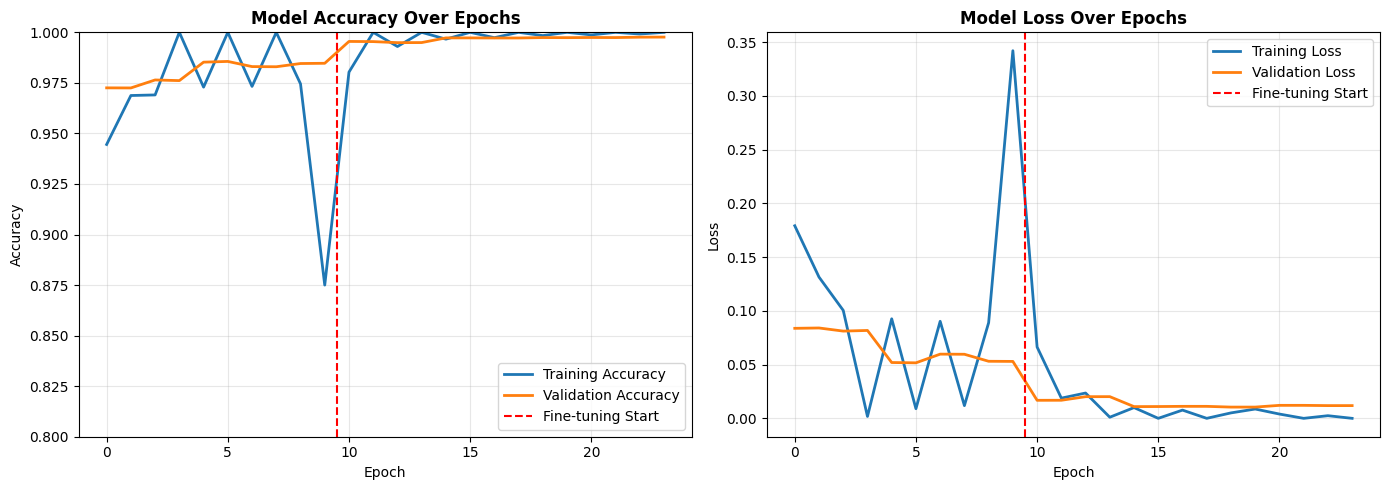


Plot saved to: /content/efficientnet_training_history.png

Training Summary:
  Total epochs:         24
  Phase 1 epochs:       10
  Phase 2 epochs:       14
  Best epoch:           24
  Best val accuracy:    0.9976 (99.76%)
  Total training time:  3:54:21.117172


In [9]:
# ================================================================
# CELL 9: PLOT TRAINING HISTORY
# ================================================================
# Combines both training phases into unified plots.
# ================================================================

print("=" * 65)
print("TRAINING HISTORY")
print("=" * 65)

# Combine histories from both phases
combined_history = {
    'accuracy': history_phase1.history['accuracy'] + history_phase2.history['accuracy'],
    'val_accuracy': history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy'],
    'loss': history_phase1.history['loss'] + history_phase2.history['loss'],
    'val_loss': history_phase1.history['val_loss'] + history_phase2.history['val_loss']
}

total_epochs = len(combined_history['accuracy'])
phase1_epochs = len(history_phase1.history['accuracy'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# -----------------------------
# ACCURACY PLOT
# -----------------------------
axes[0].plot(combined_history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(combined_history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].axvline(x=phase1_epochs-0.5, color='red', linestyle='--', label='Fine-tuning Start')
axes[0].set_title('Model Accuracy Over Epochs', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0.8, 1.0])

# -----------------------------
# LOSS PLOT
# -----------------------------
axes[1].plot(combined_history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(combined_history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].axvline(x=phase1_epochs-0.5, color='red', linestyle='--', label='Fine-tuning Start')
axes[1].set_title('Model Loss Over Epochs', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/efficientnet_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to: /content/efficientnet_training_history.png")

# -----------------------------
# TRAINING SUMMARY
# -----------------------------
best_val_acc = max(combined_history['val_accuracy'])
best_epoch = combined_history['val_accuracy'].index(best_val_acc) + 1

print(f"\nTraining Summary:")
print(f"  Total epochs:         {total_epochs}")
print(f"  Phase 1 epochs:       {phase1_epochs}")
print(f"  Phase 2 epochs:       {total_epochs - phase1_epochs}")
print(f"  Best epoch:           {best_epoch}")
print(f"  Best val accuracy:    {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"  Total training time:  {total_training_time}")

In [10]:
# ================================================================
# CELL 10: EVALUATE ON TEST SET
# ================================================================
# Final evaluation on the held-out test set.
# ================================================================

print("=" * 65)
print("TEST SET EVALUATION")
print("=" * 65)

# Load the best model
print("\nLoading best model from checkpoint...")
best_model = keras.models.load_model(BEST_MODEL_PATH)

# Reset test generator
test_generator.reset()

# Evaluate on test set
print("Evaluating on test set...")
test_loss, test_accuracy = best_model.evaluate(
    test_generator,
    steps=len(test_generator),
    verbose=1
)

print(f"\n{'=' * 40}")
print(f"TEST RESULTS")
print(f"{'=' * 40}")
print(f"Test Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss:      {test_loss:.4f}")

TEST SET EVALUATION

Loading best model from checkpoint...
Evaluating on test set...
785/785 ━━━━━━━━━━━━━━━━━━━━ 45s 47ms/step - accuracy: 0.9982 - loss: 0.0087

TEST RESULTS
Test Accuracy:  0.9974 (99.74%)
Test Loss:      0.0113


DETAILED CLASSIFICATION METRICS

Generating predictions on test set...
785/785 ━━━━━━━━━━━━━━━━━━━━ 38s 41ms/step

CLASSIFICATION REPORT
                   precision    recall  f1-score   support

            apple     0.9962    0.9990    0.9976     10409
           banana     0.9964    0.9790    0.9876       856
bell_pepper_green     1.0000    1.0000    1.0000       156
  bell_pepper_red     1.0000    1.0000    1.0000       234
           carrot     1.0000    1.0000    1.0000        61
         cucumber     1.0000    1.0000    1.0000      2367
            grape     0.9879    0.9835    0.9857      1330
            lemon     1.0000    1.0000    1.0000       272
            onion     1.0000    1.0000    1.0000      1050
           orange     1.0000    1.0000    1.0000       489
            peach     1.0000    1.0000    1.0000      1650
           potato     1.0000    1.0000    1.0000       429
       strawberry     0.9918    0.9758    0.9838       621
           tomato     0.9998    1.00

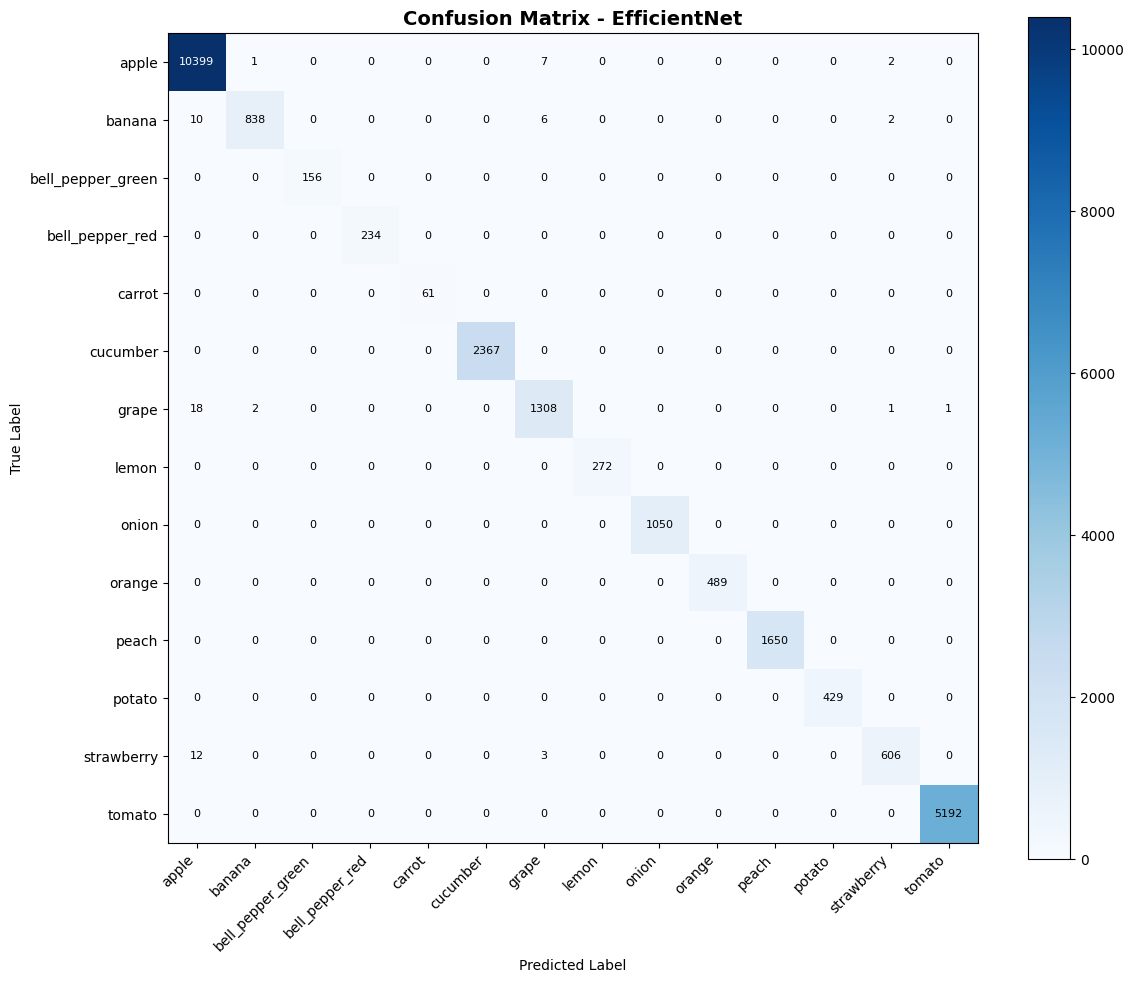


Confusion matrix saved to: /content/efficientnet_confusion_matrix.png


In [13]:
# ================================================================
# CELL 11: CLASSIFICATION REPORT & CONFUSION MATRIX
# ================================================================
# Detailed per-class metrics and confusion matrix visualization.
# ================================================================

print("=" * 65)
print("DETAILED CLASSIFICATION METRICS")
print("=" * 65)

# Reset test generator and get predictions
test_generator.reset()

print("\nGenerating predictions on test set...")
predictions = best_model.predict(test_generator, steps=len(test_generator), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# -----------------------------
# CLASSIFICATION REPORT
# -----------------------------
print("\n" + "=" * 65)
print("CLASSIFICATION REPORT")
print("=" * 65)

report = classification_report(
    true_classes,
    predicted_classes,
    target_names=class_labels,
    digits=4
)
print(report)

# Store report as dictionary for later use
report_dict = classification_report(
    true_classes,
    predicted_classes,
    target_names=class_labels,
    output_dict=True
)

# -----------------------------
# CONFUSION MATRIX
# -----------------------------
print("=" * 65)
print("CONFUSION MATRIX")
print("=" * 65)

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(12, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - EfficientNet', fontsize=14, fontweight='bold')
plt.colorbar()

tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45, ha='right')
plt.yticks(tick_marks, class_labels)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=8)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('/content/efficientnet_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nConfusion matrix saved to: /content/efficientnet_confusion_matrix.png")

In [14]:
# ================================================================
# CELL 12: MEASURE INFERENCE TIME
# ================================================================
# Measures average inference time per image.
# Critical metric for comparing model efficiency.
# ================================================================

import time

print("=" * 65)
print("INFERENCE TIME MEASUREMENT")
print("=" * 65)

# Get a batch of test images
test_generator.reset()
test_batch, _ = next(test_generator)

# Warm-up run
_ = best_model.predict(test_batch[:1], verbose=0)

# -----------------------------
# SINGLE IMAGE INFERENCE
# -----------------------------
print("\nMeasuring single image inference time...")

single_image = test_batch[:1]
n_runs = 100

times = []
for _ in range(n_runs):
    start = time.perf_counter()
    _ = best_model.predict(single_image, verbose=0)
    end = time.perf_counter()
    times.append((end - start) * 1000)

single_avg = np.mean(times)
single_std = np.std(times)

print(f"  Runs:          {n_runs}")
print(f"  Average:       {single_avg:.2f} ms")
print(f"  Std Dev:       {single_std:.2f} ms")

# -----------------------------
# BATCH INFERENCE
# -----------------------------
print("\nMeasuring batch inference time...")

batch_size = 32
batch_images = test_batch[:batch_size]
n_runs = 50

times = []
for _ in range(n_runs):
    start = time.perf_counter()
    _ = best_model.predict(batch_images, verbose=0)
    end = time.perf_counter()
    times.append((end - start) * 1000)

batch_avg = np.mean(times)
batch_std = np.std(times)
per_image_batch = batch_avg / batch_size

print(f"  Batch size:    {batch_size}")
print(f"  Runs:          {n_runs}")
print(f"  Batch avg:     {batch_avg:.2f} ms")
print(f"  Per image:     {per_image_batch:.2f} ms")

# -----------------------------
# STORE RESULTS
# -----------------------------
INFERENCE_TIME_SINGLE = single_avg
INFERENCE_TIME_BATCH = per_image_batch

print(f"\n{'=' * 40}")
print("INFERENCE TIME SUMMARY")
print(f"{'=' * 40}")
print(f"Single image:   {INFERENCE_TIME_SINGLE:.2f} ms")
print(f"Batched (x32):  {INFERENCE_TIME_BATCH:.2f} ms per image")

INFERENCE TIME MEASUREMENT

Measuring single image inference time...
  Runs:          100
  Average:       61.16 ms
  Std Dev:       1.83 ms

Measuring batch inference time...
  Batch size:    32
  Runs:          50
  Batch avg:     250.43 ms
  Per image:     7.83 ms

INFERENCE TIME SUMMARY
Single image:   61.16 ms
Batched (x32):  7.83 ms per image


In [15]:
# ================================================================
# CELL 13: SAVE MODEL & RESULTS SUMMARY
# ================================================================
# Saves the trained model and all metrics to Google Drive.
# ================================================================

import json

print("=" * 65)
print("SAVING MODEL & RESULTS")
print("=" * 65)

# -----------------------------
# SAVE MODEL TO DRIVE
# -----------------------------
DRIVE_MODEL_DIR = "/content/drive/MyDrive/snapshelf_models"
os.makedirs(DRIVE_MODEL_DIR, exist_ok=True)

MODEL_SAVE_PATH = f"{DRIVE_MODEL_DIR}/efficientnet_model.keras"

print(f"\nSaving model to: {MODEL_SAVE_PATH}")
best_model.save(MODEL_SAVE_PATH)
print("Model saved successfully.")

# Get model file size
model_size_mb = os.path.getsize(MODEL_SAVE_PATH) / (1024 * 1024)

# -----------------------------
# COMPILE RESULTS
# -----------------------------
total_params = best_model.count_params()

results = {
    "model_name": "EfficientNetB0",
    "architecture": {
        "type": "Transfer Learning",
        "base_model": "EfficientNetB0",
        "pretrained_on": "ImageNet",
        "fine_tuned_layers": 72,
        "frozen_layers": 166,
        "input_size": list(IMG_SIZE),
        "num_classes": NUM_CLASSES
    },
    "training": {
        "phase1_epochs": len(history_phase1.history['loss']),
        "phase2_epochs": len(history_phase2.history['loss']),
        "total_epochs": len(history_phase1.history['loss']) + len(history_phase2.history['loss']),
        "training_time_seconds": TRAINING_TIME_SECONDS,
        "batch_size": BATCH_SIZE,
        "optimizer": "Adam",
        "phase1_learning_rate": 0.001,
        "phase2_learning_rate": 0.0001
    },
    "performance": {
        "val_accuracy": float(max(combined_history['val_accuracy'])),
        "test_accuracy": float(test_accuracy),
        "test_loss": float(test_loss)
    },
    "per_class_metrics": {
        class_name: {
            "precision": report_dict[class_name]["precision"],
            "recall": report_dict[class_name]["recall"],
            "f1_score": report_dict[class_name]["f1-score"],
            "support": report_dict[class_name]["support"]
        }
        for class_name in class_labels
    },
    "efficiency": {
        "total_parameters": int(total_params),
        "model_size_mb": round(model_size_mb, 2),
        "inference_time_single_ms": round(INFERENCE_TIME_SINGLE, 2),
        "inference_time_batch_ms": round(INFERENCE_TIME_BATCH, 2)
    }
}

# -----------------------------
# SAVE RESULTS JSON
# -----------------------------
RESULTS_PATH = f"{DRIVE_MODEL_DIR}/efficientnet_results.json"

print(f"\nSaving results to: {RESULTS_PATH}")
with open(RESULTS_PATH, 'w') as f:
    json.dump(results, f, indent=2)
print("Results saved successfully.")

# -----------------------------
# SAVE PLOTS TO DRIVE
# -----------------------------
print(f"\nSaving plots to Drive...")
shutil.copy('/content/efficientnet_training_history.png',
            f"{DRIVE_MODEL_DIR}/efficientnet_training_history.png")
shutil.copy('/content/efficientnet_confusion_matrix.png',
            f"{DRIVE_MODEL_DIR}/efficientnet_confusion_matrix.png")
print("Plots saved successfully.")

# -----------------------------
# PRINT FINAL SUMMARY
# -----------------------------
print("\n" + "=" * 65)
print("EFFICIENTNET - FINAL RESULTS SUMMARY")
print("=" * 65)

print(f"""
MODEL ARCHITECTURE
------------------
Type:               Transfer Learning (EfficientNetB0)
Pre-trained on:     ImageNet
Fine-tuned layers:  72 / 238
Total Parameters:   {total_params:,}
Model Size:         {model_size_mb:.2f} MB

TRAINING
--------
Phase 1 (frozen):   {len(history_phase1.history['loss'])} epochs
Phase 2 (fine-tune): {len(history_phase2.history['loss'])} epochs
Total epochs:       {len(history_phase1.history['loss']) + len(history_phase2.history['loss'])}
Training Time:      {total_training_time}

PERFORMANCE
-----------
Validation Accuracy:  {max(combined_history['val_accuracy'])*100:.2f}%
Test Accuracy:        {test_accuracy*100:.2f}%
Test Loss:            {test_loss:.4f}

EFFICIENCY
----------
Inference (single):   {INFERENCE_TIME_SINGLE:.2f} ms
Inference (batch):    {INFERENCE_TIME_BATCH:.2f} ms/image

FILES SAVED
-----------
Model:    {MODEL_SAVE_PATH}
Results:  {RESULTS_PATH}
Plots:    {DRIVE_MODEL_DIR}/efficientnet_*.png
""")

print("=" * 65)
print("NOTEBOOK 03 COMPLETE")
print("=" * 65)

SAVING MODEL & RESULTS

Saving model to: /content/drive/MyDrive/snapshelf_models/efficientnet_model.keras
Model saved successfully.

Saving results to: /content/drive/MyDrive/snapshelf_models/efficientnet_results.json
Results saved successfully.

Saving plots to Drive...
Plots saved successfully.

EFFICIENTNET - FINAL RESULTS SUMMARY

MODEL ARCHITECTURE
------------------
Type:               Transfer Learning (EfficientNetB0)
Pre-trained on:     ImageNet
Fine-tuned layers:  72 / 238
Total Parameters:   4,072,625
Model Size:         40.03 MB

TRAINING
--------
Phase 1 (frozen):   10 epochs
Phase 2 (fine-tune): 14 epochs
Total epochs:       24
Training Time:      3:54:21.117172

PERFORMANCE
-----------
Validation Accuracy:  99.76%
Test Accuracy:        99.74%
Test Loss:            0.0113

EFFICIENCY
----------
Inference (single):   61.16 ms
Inference (batch):    7.83 ms/image

FILES SAVED
-----------
Model:    /content/drive/MyDrive/snapshelf_models/efficientnet_model.keras
Results:  /co